In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, udf, array, min as smin, lit, count, isnan, when, sum as spark_sum, rand
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, expr
from pyspark.sql.functions import explode
from sklearn.datasets import fetch_kddcup99
from sklearn.metrics.pairwise import euclidean_distances


import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType, StructField, DoubleType

import matplotlib.pyplot as plt

In [2]:
def initiate_session(ncores, spark=spark):
    
    spark.stop()

    spark = SparkSession.builder \
        .config("spark.executor.cores", str(ncores))\
        .master("spark://10.67.22.21:7077")\
        .appName("k-meaner")\
        .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.2.0')\
        .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0')\
        .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.11.375')\
        .config("spark.executor.memory", "4096m")\
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
        .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
        .config('spark.hadoop.fs.s3a.access.key', '79f100fb66c34d338833171110cb12fe')\
        .config('spark.hadoop.fs.s3a.secret.key', '--------------------------------')\
        .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
        .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
        .config("spark.hadoop.fs.s3a.path.style.access", "true") \
        .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
        .config("com.amazonaws.sdk.disableCertChecking","true") \
        .getOrCreate()

    sc = spark.sparkContext
    sc.setLogLevel("ERROR")
    
    return spark, sc

ncores = 4
# 4 cores
spark, sc = initiate_session(ncores=ncores)

In [3]:
spark

In [4]:
sc

<SparkContext master=spark://10.67.22.21:7077 appName=k-meaner>

# BEST RANDOM KMEANS

In [7]:
# load data
kdd = spark.createDataFrame(pd.read_csv("./data.csv"))

# List of columns to be ignored

ignored_cols = ["labels", "centr", "cost", "w"]

ncols = len([c for c in kdd.columns if c not in ignored_cols]) #n° of columns ccontaining the actual data

#kdd.printSchema()

In [5]:
#%%writefile kmeans_random.py

# Function to calculate Euclidean distance between two points x and y
def euclidean_distance(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))

# Function to find the index of the minimum value in a list x
def argmin(x):
    return x.index(min(x))

# Function to initialize K-Means with random centers
def random_choice_init(data, k):
    # Select relevant columns and take k random samples
    three_dim_array = np.array(data.select(array([c for c in data.columns if c not in ignored_cols])).rdd.takeSample(False, k))
    final = three_dim_array.reshape(three_dim_array.shape[0], -1)
    return final

# Main K-Means function
def kmeans(data, centers, max_iter=100, perc=0.999999, return_cost=False):
    count = 0

    # Get column names
    cols = data.columns

    # Initialize cost history 
    cost = [float("inf")]

    # Main K-Means loop
    while count <= max_iter:
        print("Iteration", count)

        # Define a UDF to find the index of the nearest center for each row
        argmin_distance_udf = udf(lambda row: (argmin([euclidean_distance(row, c) for c in centers])), IntegerType())

        # Calculate the "centr" column based on the nearest center
        data = data.withColumn("centr", argmin_distance_udf(array([c for c in cols if c not in ignored_cols])))

        # Update the centers based on the assigned clusters
        
        centers = np.array(data.groupBy("centr").mean().select(*[col("avg("+c+")") for c in data.columns if c not in ignored_cols+['avg(centr)']]).collect())

        # Calculate the cost value per element, then sum
        get_cost = udf(lambda row: str(min([euclidean_distance(row, cen)**2 for cen in centers])))

        data = data.withColumn("cost", get_cost(array([c for c in cols if c not in ignored_cols])).cast("double"))

        # Calculate the new cost and add it to the cost history
        finalcost = data.select("cost").groupBy().sum().collect()[0][0]
        cost.append(finalcost)
        
        print("Cost function values", cost[count])

        # Increment the iteration count
        count += 1

        # Break if the cost change ratio is below the specified threshold
        if cost[-1] / cost[-2] > perc:
            break

    # Return the result based on whether cost history is requested
    if return_cost:
        return data, centers, cost[1:]
    else:
        return data, centers

In [14]:
def avg_cost_time_results(k, data, partitions, iterations, func, L=None):
    
    total_cost_history = np.zeros(len(partitions))
    total_time = np.zeros(len(partitions))
    
    for part in partitions:
        part_cost = list()
        part_time = list()
        for i in range(iterations):
            start_time = time.time()
            data = data.repartition(int(part))
            data = data.persist()
            r_centr = func(data, k)
            result, final_centroids, cost_history = kmeans(data, r_centr, max_iter=15, return_cost=True)
            part_cost.append(np.array(cost_history))
            elapsed_time = time.time() - start_time
            part_time.append(elapsed_time)
            

    return part_cost, part_time


In [20]:
ncores = 3
spark, sc = initiate_session(ncores=ncores, spark=spark)

data = spark.createDataFrame(pd.read_csv("./data.csv"))
k = 23 # length of unique labels
partitions = np.array([16])
iterations = 5


part_cost, part_time = avg_cost_time_results(k=k, data=data, partitions=partitions, iterations=iterations,
                                                   func=random_choice_init)

Iteration 0


Cost function values inf
Iteration 1


Cost function values 8956989.601979231
Iteration 2


Cost function values 8904482.37037084
Iteration 3


Cost function values 8741533.989231333
Iteration 4


Cost function values 8369312.1582704615
Iteration 5


Cost function values 7863975.837079446
Iteration 6


Cost function values 7773424.987593739
Iteration 7


Cost function values 7717491.58630231
Iteration 8


Cost function values 7701608.582284784
Iteration 9


Cost function values 7688567.047513449
Iteration 10


Cost function values 7678105.640332552
Iteration 11


Cost function values 7676828.976348989
Iteration 12


Cost function values 7675950.080892273
Iteration 13


Cost function values 7674136.820340304
Iteration 14


Cost function values 7661905.6902870545
Iteration 15


Cost function values 7573860.35516868


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9563243.519742493
Iteration 2


Cost function values 8996214.250479668
Iteration 3


Cost function values 8617311.054963231
Iteration 4


Cost function values 8568004.93780889
Iteration 5


Cost function values 8553443.065381907
Iteration 6


Cost function values 8525965.24185946
Iteration 7


Cost function values 8444168.006371953
Iteration 8


Cost function values 8345357.289155557
Iteration 9


Cost function values 8273515.78803671
Iteration 10


Cost function values 8205782.97167193
Iteration 11


Cost function values 8195205.125978409
Iteration 12


Cost function values 8193326.7222835515
Iteration 13


Cost function values 8191924.440072211
Iteration 14


Cost function values 8177063.380050134
Iteration 15


Cost function values 8045592.307430963


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9111202.411372723
Iteration 2


Cost function values 8204921.154740699
Iteration 3


Cost function values 7775696.281781221
Iteration 4


Cost function values 7767470.175999577
Iteration 5


Cost function values 7765241.621751914
Iteration 6


Cost function values 7699411.5570903905
Iteration 7


Cost function values 7644711.069304806
Iteration 8


Cost function values 7641041.469664875
Iteration 9


Cost function values 7640407.148759229
Iteration 10


Cost function values 7640310.23842993
Iteration 11


Cost function values 7640294.516146548


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9475870.508118251
Iteration 2


Cost function values 9204758.924747562
Iteration 3


Cost function values 8987566.382945638
Iteration 4


Cost function values 8904379.978657655
Iteration 5


Cost function values 8897151.654044995
Iteration 6


Cost function values 8896819.255504409
Iteration 7


Cost function values 8895000.923754018
Iteration 8


Cost function values 8893157.284565883
Iteration 9


Cost function values 8887329.0494671
Iteration 10


Cost function values 8881286.474310867
Iteration 11


Cost function values 8819154.325296499
Iteration 12


Cost function values 8418507.323541183
Iteration 13


Cost function values 8355174.990636323
Iteration 14


Cost function values 8351539.250434652
Iteration 15


Cost function values 8350955.663757862


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9514193.003628926
Iteration 2


Cost function values 9201954.581230685
Iteration 3


Cost function values 9118455.606488515
Iteration 4


Cost function values 9061629.3041859
Iteration 5


Cost function values 8962997.120824702
Iteration 6


Cost function values 8694333.959504895
Iteration 7


Cost function values 8426999.118036455
Iteration 8


Cost function values 8120365.694959196
Iteration 9


Cost function values 8023970.34040447
Iteration 10


Cost function values 7915238.359605302
Iteration 11


Cost function values 7436085.0626894
Iteration 12


Cost function values 7361181.485223055
Iteration 13


Cost function values 7298307.17761414
Iteration 14


Cost function values 7289855.846724051
Iteration 15


Cost function values 7289009.739898003


In [31]:
def pad_arrays(arrays):
    max_length = max(len(arr) for arr in arrays)
    padded_arrays = []
    for arr in arrays:
        pad_length = max_length - len(arr)
        padded_arr = np.pad(arr, (0, pad_length), mode='constant')
        padded_arrays.append(padded_arr)
    return padded_arrays

In [59]:
part_cost = pad_arrays(part_cost)

part_time = np.array(part_time)
part_cost = np.array(part_cost)

# Mask padded values
mask = (part_cost != 0)

# Calculate average and standard deviation over columns considering non-padded elements only
avg_cost = np.sum(part_cost * mask, axis=0) / np.sum(mask, axis=0)
std_cost = np.sqrt(np.sum(((part_cost - avg_cost) ** 2) * mask, axis=0) / np.sum(mask, axis=0))

avg_time = np.mean(part_time)
std_time = np.std(part_time)


# BEST PARALLEL KMEANS

In [24]:
    
def kmeans_Lloyd(X, centroids, k, max_iters=100, tol=1e-7):
    
    """ Run the sequential LLoyd algorithm given data X, centroids and k number of clusters."""

    costs = []

    for _ in range(max_iters):
        # Step 1: Assign each data point to the nearest centroid
        distances = euclidean_distances(X, centroids)
        labels = np.argmin(distances, axis=1)
        
        # Step 2: Update centroids based on the assigned points
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        # Calculate the cost function (sum of squared distances to centroids)
        cost = np.sum(np.min(distances, axis=1))
        costs.append(cost)

        
        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) <= tol:
            break
        
        centroids = new_centroids
    
    return centroids, labels, costs



In [25]:
def kmeans_Lloyd(X, centroids, k, max_iters=100, tol=1e-7):
    
    """ Run the sequential LLoyd algorithm given data X, centroids and k number of clusters."""

    costs = []

    for _ in range(max_iters):
        # Step 1: Assign each data point to the nearest centroid
        distances = euclidean_distances(X, centroids)
        labels = np.argmin(distances, axis=1)
        
        # Step 2: Update centroids based on the assigned points
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        # Calculate the cost function (sum of squared distances to centroids)
        cost = np.sum(np.min(distances, axis=1))
        costs.append(cost)

        
        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) <= tol:
            break
        
        centroids = new_centroids
    
    return centroids, labels, costs



def kmeans_ll(data, k, L=1): 
    
    """ || kmeans initialization of k centroids elements. X is the data, L the oversampling factor."""
    
    
    cols = data.columns
    n_samples, n_features = data.count(), len(data.columns)
    centroids = np.zeros((1, n_features))
    
    # Step 1: Choose one random point as the first centroid
    three_dim_array = np.array(data.select(array([c for c in data.columns if c not in ignored_cols])).rdd.takeSample(False, 1))
    centroids[0] = three_dim_array.reshape(three_dim_array.shape[0], -1)
    
    # Define a UDF to find psi
    # Calculate the distance using the UDF and collect the result
    distance_udf = udf(lambda row: ((float(euclidean_distance(row, centroids[0])))), DoubleType())

    distance = data.withColumn("distance", distance_udf(array([c for c in cols if c not in ignored_cols])))

    # Sum the distances
    psi = distance.select(spark_sum(col("distance"))).collect()[0][0]
    #print(psi)

    

    # Calculate psi
    #psi = spark_sum(distance_udf(array([c for c in cols if c not in ignored_cols])).collect())

    
    for j in range(1, int(np.log(psi))):

        # Step 2: Compute distances from each point to the nearest centroid and define probabilities
        min_distance_udf = udf(lambda row: (float(min([euclidean_distance(row, c) for c in centroids]))), DoubleType())
        data = data.withColumn("probs", min_distance_udf(array([c for c in cols if c not in ignored_cols])))
        # Calculate the sum of the "probs" column
        total_sum = data.select(spark_sum(col("probs"))).collect()[0][0]
        # Normalize the "probs" column by dividing each row's value by the total sum
        data = data.withColumn("probs", col("probs")*L / total_sum)
        
        # Sample and add centroids
        # Generate a random column for filtering
        data = data.withColumn("rand_col", rand())

        # Filter and select the rows where 'rand_col' is less than 'probs' to get n_samples
        selected_data = data.filter(col("rand_col") < col("probs")).select([col(c) for c in data.columns if c not in ['rand_col','centr','cost','probs']]).collect()

        #print("centroids", centroids)
        #print("selected_data", selected_data)
        if selected_data != []:
            centroids = np.concatenate((centroids, selected_data), axis=0)
                
    if len(centroids) > k:
                
        #A SORT OF K MEANS ++ INITIALIAZATION FOR Lloyd ITERATIONS ON CENTROIDS       
        cc = np.copy(centroids)
        p_centroids = np.zeros((k, n_features))

        for j in range(0, k):
            
            # Define weights
            w = np.zeros(len(cc))

            # Create new column with the index of the nearest center for each row
            argmin_distance_udf = udf(lambda row: (argmin([euclidean_distance(row, c) for c in cc])), IntegerType())
            data = data.withColumn("index", argmin_distance_udf(array([c for c in cols if c not in ignored_cols])))

            #w = np.array(data.groupBy("index").count().collect())
            # Group by 'centroid_inddex' and count the occurrences, renaming the count column
            centroid_counts = data.groupBy("index").count()
            # Order by ascending index value
            centroid_counts = centroid_counts.sort("index")
            # Calculate the sum of counts
            total_count = centroid_counts.select(spark_sum(col("count"))).collect()[0][0]
            # Normalize the "probs" column by dividing each row's value by the total sum
            renormalized_counts = centroid_counts.withColumn("count", col("count")/ total_count).select(col("count")).collect()
            probs = np.array(renormalized_counts).flatten()

            next_centroid_idx = np.random.choice(len(probs), p=probs)
            p_centroids[j] = cc[next_centroid_idx]
            cc = np.delete(cc, next_centroid_idx, axis=0)

        #print(len(centroids), len(p_centroids))
        # K MEANS Lloyd ITERATIONS ON CENTROIDS

        final_centroids, __, _ = kmeans_Lloyd(centroids, p_centroids, k)
    else:
        final_centroids = centroids
        
    return final_centroids


In [26]:
ncores = 3
# 4 cores
spark, sc = initiate_session(ncores=ncores, spark=spark)

In [28]:
data = spark.createDataFrame(pd.read_csv("./data.csv"))
k = 23 # length of unique labels
partitions = np.array([32])
iterations = 5

part_cost_ll, part_time_ll =  avg_cost_time_results(k=k, data=data, partitions=partitions, iterations=iterations,
                                                   func=kmeans_ll, L=1)

Iteration 0


Cost function values inf
Iteration 1


Cost function values 6691059.31377656
Iteration 2


Cost function values 6446053.655031749
Iteration 3


Cost function values 6196412.060850556
Iteration 4


Cost function values 6145320.231456628
Iteration 5


Cost function values 6129917.182387537
Iteration 6


Cost function values 6104366.078180213
Iteration 7


Cost function values 6053710.209627607
Iteration 8


Cost function values 6051487.193159205
Iteration 9


Cost function values 6051355.549449811
Iteration 10


Cost function values 6050553.598292772
Iteration 11


Cost function values 6045812.076494363
Iteration 12


Cost function values 6012890.602163393
Iteration 13


Cost function values 5668722.367608393
Iteration 14


Cost function values 5602030.653939595
Iteration 15


Cost function values 5599548.300071866


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8280102.6156306
Iteration 2


Cost function values 7846784.87922548
Iteration 3


Cost function values 7638784.229894099
Iteration 4


Cost function values 7596767.967821854
Iteration 5


Cost function values 7595641.916635383
Iteration 6


Cost function values 7595560.884856804
Iteration 7


Cost function values 7595547.215405993


Iteration 0


Cost function values inf
Iteration 1


Cost function values 9008150.830829425
Iteration 2


Cost function values 8819104.076554883
Iteration 3


Cost function values 8763800.537609184
Iteration 4


Cost function values 8727773.490051398
Iteration 5


Cost function values 8716123.403448084
Iteration 6


Cost function values 8707196.544812078
Iteration 7


Cost function values 8703779.7110516
Iteration 8


Cost function values 8702159.72768776
Iteration 9


Cost function values 8701107.623932654
Iteration 10


Cost function values 8695147.249352677
Iteration 11


Cost function values 8692869.973045
Iteration 12


Cost function values 8692038.927889377
Iteration 13


Cost function values 8690002.758973341
Iteration 14


Cost function values 8666259.8081417
Iteration 15


Cost function values 8524902.392168734


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8373762.116951124
Iteration 2


Cost function values 7509842.330537876
Iteration 3


Cost function values 7146342.238411474
Iteration 4


Cost function values 7126499.734027796
Iteration 5


Cost function values 7121094.783562107
Iteration 6


Cost function values 7119004.581470822
Iteration 7


Cost function values 7117237.581816428
Iteration 8


Cost function values 7115395.618716272
Iteration 9


Cost function values 7114769.977197345
Iteration 10


Cost function values 7114367.357594196
Iteration 11


Cost function values 7114075.820098166
Iteration 12


Cost function values 7113781.041682037
Iteration 13


Cost function values 7113502.258198252
Iteration 14


Cost function values 7113311.373592409
Iteration 15


Cost function values 7113210.850990934


Iteration 0


Cost function values inf
Iteration 1


Cost function values 8972828.92405828
Iteration 2


Cost function values 8789834.29285686
Iteration 3


Cost function values 8773938.04682192
Iteration 4


Cost function values 8765096.777863715
Iteration 5


Cost function values 8739652.224155951
Iteration 6


Cost function values 8704871.371414676
Iteration 7


Cost function values 8696004.190604532
Iteration 8


Cost function values 8694091.158258382
Iteration 9


Cost function values 8693719.536082473
Iteration 10


Cost function values 8693521.4612246
Iteration 11


Cost function values 8693219.271669399
Iteration 12


Cost function values 8693183.72605247


In [70]:
part_cost_ll = pad_arrays(part_cost_ll)

part_time_ll = np.array(part_time_ll)
part_cost_ll = np.array(part_cost_ll)

# Mask padded values
mask_ll = (part_cost_ll != 0)

# Calculate average and standard deviation over columns considering non-padded elements only
avg_cost_ll = np.sum(part_cost_ll * mask_ll, axis=0) / np.sum(mask_ll, axis=0)
std_cost_ll = np.sqrt(np.sum(((part_cost_ll - avg_cost_ll) ** 2) * mask_ll, axis=0) / np.sum(mask_ll, axis=0))

avg_time_ll = np.mean(part_time_ll)
std_time_ll = np.std(part_time_ll)


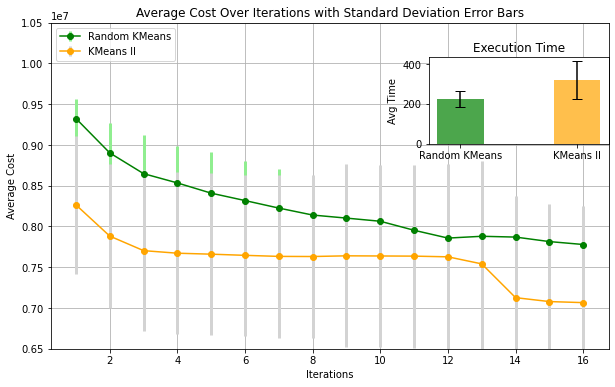

In [100]:
# Plotting the average cost over iterations with error bars representing standard deviation
plt.figure(figsize=(10, 6))
plt.errorbar(range(1, len(avg_cost) + 1), avg_cost, yerr=std_cost, fmt='o-', color='green', ecolor='lightgreen', elinewidth=3, capsize=0, label='Random KMeans')
plt.errorbar(range(1, len(avg_cost_ll) + 1), avg_cost_ll, yerr=std_cost_ll, fmt='o-', color='orange', ecolor='lightgray', elinewidth=3, capsize=0, label='KMeans ll')
plt.xlabel('Iterations')
plt.ylabel('Average Cost')
plt.title('Average Cost Over Iterations with Standard Deviation Error Bars')
plt.ylim(6.5*1e6, 10.5*1e6)
plt.grid(True)
plt.legend(loc='upper left')

# Creating a bar plot in the top right corner for avg_time and avg_time * 2
ax = plt.axes([0.65, 0.6, 0.25, 0.2])  # [left, bottom, width, height]
ax.bar(1, avg_time, width=0.4, align='center', alpha=0.7, color='green', label='Random KMeans', yerr=std_time, capsize=5)
ax.bar(2, avg_time_ll, width=0.4, align='center', alpha=0.7, color='orange', label='KMeans ll', yerr=std_time_ll, capsize=5)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Random KMeans', 'KMeans ll'])
ax.set_ylabel('Avg Time')
ax.set_title('Execution Time')


# Set legend for both the plots
plt.show()